In [44]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [1]:
import pandas as pd
import csv
import os
import numpy
import copy
%matplotlib inline
import numpy as np
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, similarities, matutils
from gensim.corpora.dictionary import Dictionary
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF, PCA
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from collections import Counter, defaultdict, OrderedDict
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

#Some nice plotting params
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 3
plt.style.use('ggplot')

# Load ISIS data set and clean tweets

In [5]:
df = pd.read_csv('/media/patrick/MY_EXTERNAL/ISIS/tweets.csv', parse_dates= [6])

In [6]:
df.username = df.username.str.lower()

In [7]:
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [8]:
def clean_tweet(tweet):
    ext = "http"
    text = tweet[:tweet.find(ext)].lower()
    text = re.sub("[^\S]", " ", text)
    text = re.sub("english translation ", "", text)
    textOnly = re.sub("[^a-zA-Z0-9@# ]", "", text)
    return(textOnly)

In [9]:
def remove_users(tweet):
    text = tweet.lower()
    textOnly = re.sub(r"@\w+", "", text)
    return(textOnly)

In [10]:
df.tweets = df.tweets.apply(clean_tweet)

In [11]:
infoDict = OrderedDict()
for r in df[['username','tweets']].iterrows():
    match = re.search('^rt', r[1][1])
    if match:
        m = list(re.findall(r"@\w+", r[1][1]))
        if m:
            username=m[0][1:]
            tweet=r[1][1][len('rt ' + m[0]):] +' @' + r[1][0]
    else:
        username=r[1][0]
        tweet=r[1][1]
    if username not in infoDict:
        user = {}
        user['affil'] = []
        user['hashtags'] = []
        user['tweets'] = []
        user['doc'] = ''
        infoDict[username] = user
    if tweet not in infoDict[username]['tweets']:
        infoDict[username]['tweets'].append(tweet)
        infoDict[username]['doc']+=' ' + tweet
    infoDict[username]['hashtags'].extend(re.findall('(?<=#)\w+', tweet))
    infoDict[username]['affil'].extend(re.findall('(?<=@)\w+', tweet))

### Treat all the tweets from one user as a single document and vectorize

In [12]:
len(infoDict)

1556

In [21]:
len(docs)

1556

In [19]:
docs = []
for k, v in infoDict.items():
    docs.append(remove_users(v['doc']))

In [20]:
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', #tokenizer=tokenize,
                                  ngram_range=(1,1), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
tfidf_docs = Tfidf_vectorizer.fit_transform(docs)

In [ ]:
count_vectorizer = CountVectorizer(analyzer='word',
                                  ngram_range=(1,3), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
cv_tweets = count_vectorizer.fit_transform(docs)

treat each tweets seperately

In [242]:
Tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize,
                                  ngram_range=(1,2), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
tfidf_tweets = Tfidf_vectorizer.fit_transform(df.tweets)

--------------------------------------------------------------------------

In [22]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(tfidf_docs, n_components=15,
                                      n_iter=5,
                                      random_state=None)

In [23]:
sigma = []
for k,v in enumerate(Sigma):
    sigma.append((k,v))

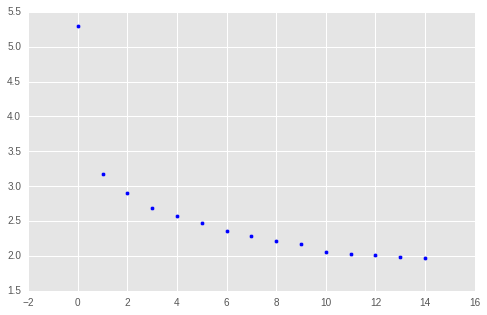

In [24]:
f = plt.scatter(*zip(*sigma))

Based on the sigma values from the resulting matrix we can choose a about 5 components to use in our NMF model in order to explain the most.....?

### NMF decomposition

In [17]:
tfidf_docs.shape

(112, 34927)

In [25]:
num_topics = 5
model = NMF(n_components=num_topics, init='random', random_state=0)
nmf = model.fit_transform(tfidf_docs)

In [26]:
doc_cluster = [list(r).index(max(r)) for r in nmf]

In [27]:
print (doc_cluster[0:20])
print (doc_cluster[41:60])
print (doc_cluster[61:80])
print( doc_cluster[-40:-20])

[3, 3, 2, 3, 3, 3, 0, 0, 2, 3, 4, 0, 0, 4, 3, 3, 4, 0, 0, 3]
[0, 0, 3, 1, 3, 3, 4, 3, 2, 3, 4, 3, 4, 1, 4, 0, 4, 2, 0]
[0, 1, 1, 3, 3, 3, 0, 4, 4, 4, 3, 0, 3, 0, 3, 2, 2, 0, 3]
[3, 2, 0, 2, 2, 2, 0, 1, 2, 2, 4, 0, 2, 4, 2, 0, 2, 3, 2, 3]


In [28]:
cluster_size = [0,0,0,0,0]
for v in doc_cluster:
    cluster_size[v]+=1
cluster_size

[410, 193, 253, 493, 207]

In [38]:
for r in df[['username']].iterrows()

<generator object DataFrame.iterrows at 0x7fa66803ce60>

In [36]:
# create dictionary that maps a user to their specific cluster
user_docs = {}
for k, cluster in enumerate(doc_cluster):
    user_docs[df['username'].iterrows()[k]] = cluster

AttributeError: 'Series' object has no attribute 'iterrows'

In [29]:
words = sorted([(i,v) for v,i in Tfidf_vectorizer.vocabulary_.items()])
topic_words = []
for r in model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([words[e[1]] for e in a])

In [30]:
# VINNY"S CODE!
# Create the a list of topic words but only inlude them if they are the highest among all clusters
# they also need to be weighted appropriately within their cluster


word_cluster = [(list(r).index(max(r)),max(r)) for r in model.components_.transpose()]
for i,r in enumerate(model.components_.transpose()):
    s = sorted(r)
    if (s[0]-s[1])/s[1]<0.25:
        word_cluster[i] = (-1,-1)
topic_words = []
for c in range(5):
    a = sorted([(v[1],i) for i,v in enumerate(word_cluster) if v[0]==c], reverse=True)[0:7]
    topic_words.append([words[e[1]] for e in a])

In [31]:
topic_words

[[(9643, 'isis'),
  (11083, 'libya'),
  (13276, 'oil'),
  (17809, 'suicide'),
  (4150, 'claim'),
  (7949, 'government'),
  (602, 'airstrike')],
 [(7351, 'follow'),
  (698, 'alaikum'),
  (17985, 'suspension'),
  (10400, 'khair'),
  (2174, 'assalamu'),
  (9953, 'jazakallah'),
  (15626, 'retweet')],
 [(9682, 'islamicstate'),
  (3409, 'breaking'),
  (1521, 'amaqagency'),
  (9576, 'iraqi'),
  (6941, 'fallujah'),
  (11679, 'martyrdom'),
  (13353, 'operation')],
 [(9678, 'islamic'),
  (17569, 'state'),
  (1132, 'allah'),
  (12615, 'muslims'),
  (9670, 'islam'),
  (5961, 'dont'),
  (12602, 'muslim')],
 [(18070, 'syria'),
  (2139, 'assad'),
  (881, 'aleppo'),
  (15944, 'russian'),
  (15189, 'rebels'),
  (20557, 'ypg'),
  (15972, 'saa')]]

-----

## Creating Graph Edges

#### Currently: 
We have occurences of username strings in all tweets from each user


#### We would like: 
agrregated pairwise co-occurrence of character strings in tweet for each username, Normalized by the sum of all tweet from both usernames being compared.

In [32]:
infoDict['mustaklash']

{'affil': ['mustaklash',
  'warmonitor',
  'sayedridha',
  '1515ummah',
  '1515ummah',
  '1515ummah',
  'grezz10',
  'mankhalfahum',
  'mankhalfahum',
  'mankhalfahum'],
 'doc': ' bismillah support by retweeting may allah reward you   mustafa al iraqi  @mustaklash   amaq showing the effects of iraqi aircraft shelling on the albuhawah area in the amiriyat fallujah yesterday  iraqi forces carried out a failed attack for the 4th time within a week with the air cover on subaihat area in qrmah northeast of falluja friday prayers in tawhid masjid in the city of fallujah  ongoing battles in the vicinity of farooq dam against pkk  full album  merciful among themselves  aspect of the distribution of food aid to poor muslims  album  friday prayers in masjid alribat in the city of sirte libya  targeting the apostate yemeni armys barracks in alwadi area with a mortar shells 81 mm   @warmonitor not ye medical test laboratories in the city of albukamal  full album  destroying a convoy and killing 17

In [402]:
def is_retweet(tweet):
    match = re.search('^rt', tweet)
    if match:
        return True
    return False

In [403]:
def check_string(string):
    return string in df.username.unique()

In [55]:
count=0
rt = []
for tweet in df.tweets:
    m = re.findall(r"^rt @", tweet)
    if m:
        count+=1
        rt.append(tweet)
count
#len(set(rt))

0

In [56]:
len(infoDict)

108

In [57]:
len(set(all_mentioned_users))

NameError: name 'all_mentioned_users' is not defined

NODES

In [751]:
# create the nodes for the graph. Dictionary keys as usernames 
# with each item in the value list being a connection with number of times mentioned
# NOTE!! this is for every mentioned user

nodes = defaultdict(str)
for K, V in infoDict.items():
    nodes[K] = [(k, v) for k,v in Counter(list(V['affil'])).items() if k != K]
for k, v in list(nodes.items()):
    if not v:
        del nodes[k]

In [406]:
# create the nodes for the graph. Dictionary keys as usernames 
# with each item in the value list being a connection with number of times mentioned
# NOTE!! this is only for users within the starting data set

nodes = defaultdict(str)
for K, V in infoDict.items():
    nodes[K] = [(k, v) for k,v in Counter(list(filter(check_string, (V['affil'])))).items() if k != K]
for k, v in list(nodes.items()):
    if not v:
        del nodes[k]

In [746]:
#create dictionary that maps usernames to a uniqe ID and the cluster they belong to
# user_docs = a list of documents per user

ID = defaultdict()
for k, v in enumerate(list(nodes.items())):
    ID[v[0]] = k, user_docs[v[0]]
    for i in range(0, len(v[1])):
        try:
            ID[v[1][i][0]] = k, user_docs[v[1][i][0]]
        except:
            pass

In [54]:
df2 = pd.DataFrame(ID).T

In [755]:
nodes['ramiallolah']['affil'].most_common()

TypeError: list indices must be integers or slices, not str

In [ ]:
# save the nodes as a csv
pd.DataFrame(ID).T.to_csv('nodes2.csv')

In [ ]:
# create dict with a source, target tied to a weight
edge_dict = {}
for k, v in nodes.items():
    for i in range(len(v)):
        try:
            edge_dict[ID[[k][0]][0], ID[v[i][0]][0]] = v[i][1]
        except:
            pass

In [ ]:
pd.DataFrame([[k[0],k[1],v] for k, v in edge_dict.items()]).to_csv('edges2.csv')

In [ ]:
for k, v in edgeDict.items():
    edgeDict[k] = [word for item in v for word in item if word in list(set(df.username))]
for k, v in list(edgeDict.items()):
    if not v:
        del edgeDict[k]

In [ ]:
for k, v in edgeDict.items():
    for name in v:
        if name == k:
            v.remove(name)

Focusing on retweets

In [461]:
tweet = ' rt @mention this is a retweet'

In [602]:
retweets = defaultdict(list)
original = defaultdict(list)
all_mentioned_users = df.username.unique().tolist()
for tweet in df.tweets:
    
    m = list(re.findall(r"@\w+", tweet))
    all_mentioned_users.extend(set(m))
    
    match = re.search('^rt', tweet)
    if match:
        if m:
            retweets[m[0][1:]].append(tweet[len('rt ' + m[0]):])
            if m[0]=='@danielcollins85':
                print(tweet)

rt @danielcollins85 speculativeemotive bbc report on alleged russian strike on @msf do they report usuk bombs on innocents similarly


In [545]:
retweets = defaultdict(list)
original = []
all_mentioned_users = df.username.unique().tolist()
for tweet in df.tweets:
    match = re.search('^rt', tweet)
    if match:
        m = list(re.findall(r"@\w+", tweet))
        l = ' '.join(m)
        if m:
            retweets[m[0][1:]].append(tweet[len('rt ' + l):])
        all_mentioned_users.extend(m)
    else:
        original.append(tweet)


In [501]:
for k, v in enumerate(set(all_mentioned_users)):
    nodes
    

150

In [541]:
len([i for c in retweets.values() for i in c])

5824

In [552]:
original

defaultdict(list,
            {'04_8_1437': ['#amaqagency martyrdom operation with rigged vehicle hits a gathering of the shiite popular mobilization  #baghdad',
              '#amaqagency 3 children killed by russian airstrikes on #raqqah city yesterday  #islamicstate #khilafahnews',
              '#amaqagency  approximately 70 killed and dozens wounded after a martyrdom operation in #baghdads sadr city',
              '#amaqagency iraqi forces reconnaissance plane shot down east of #fallujah  #islamicstate #khilafahnews',
              '#amaqagency thwarted assault by syrian opposition factions on positions of islamic state forces  #qalamun',
              '#amaqagency 2 martyrdom operations with explosive belts hit #baghdads kazimiyyah area and the adl neighborhood',
              '#amaqagency #islamicstate forces capture mahjurah brigade near t4 airbase in eastern #homs countryside ',
              '#amaqagency #islamicstate fighters repel syrian opposition attack on the tanaf bord

In [551]:
len([i for c in original for i in c])

1581

In [438]:
rtwts = {}
users = []
for rt in infoDict['ramiallolah']['rts']:
    users.extend(re.findall('(?<=@)\w+', rt))
    rtwts['ramiallolah'] = [(k, v) for k,v in Counter(users).items() if k != 'ramiallolah']

In [441]:
# create dict with a source, target tied to a weight
edge2_dict = {}
for k, v in rtwts.items():
    for i in range(len(v)):
        try:
            edge2_dict[v[i][0], ID[k][0]] = v[i][1]
        except:
            pass

In [ ]:

for k in infoDict.keys():
    for v in k['rts']:
        

-----

### Time series analysis of all tweets grouped by day

In [39]:
perhr = df.set_index(pd.DatetimeIndex(df['time'])).resample('12H', how='count').resample('D', how='mean')

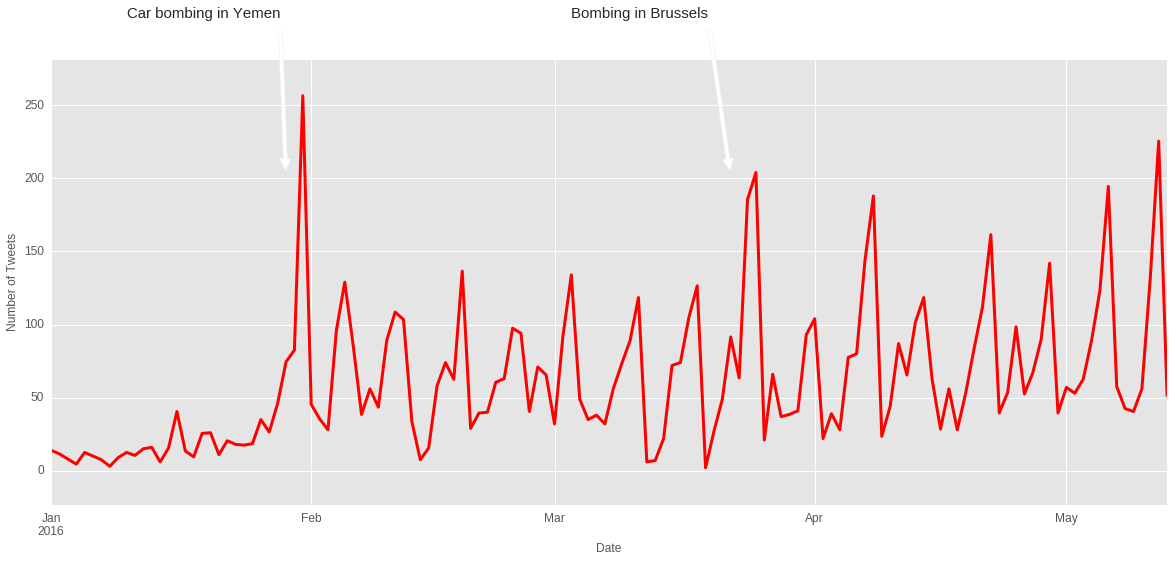

In [42]:
fig, ax = plt.subplots(figsize = (20,8))

perhr['2016-01-01':].numberstatuses.plot(ax = ax, color="r", fontsize=12)

yemen = '2016-01-29'
brussels = '2016-03-22'


# ax.plot(yemen,183,color = 'r',
#         marker = 'o',
#         markersize = 20, 
#         linestyle = '',
#        markeredgewidth = 1.5
#        )

# ax.plot(brussels,183,color = 'r',
#         marker = 'v',
#         markersize = 20, 
#         linestyle = '',
#        markeredgewidth = 1.5
#        )


ax.annotate('Bombing in Brussels',xy=(brussels, 200),xytext=('2016-03-03', 310),
            arrowprops=dict(facecolor='white', shrink=0.05), size=15)

ax.annotate('Car bombing in Yemen',xy=(yemen, 200),xytext=('2016-01-10', 310),
            arrowprops=dict(facecolor='white', shrink=0.05),size=15)

ax.margins(None,0.1)
# ax.legend(['Tweets','Car bomb in Yemen','Bombing in Brussels'], loc = 'upper left', bbox_to_anchor=(0, 0.9),
#           numpoints = 1, labelspacing = 3.5, fontsize = 18)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
#ax.set_title('Frequency of ISIS Tweets in 2016')

# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w') 
# ax.spines['right'].set_color('w')
# ax.spines['left'].set_color('w')

# ax.tick_params(axis='x', colors='w')
# ax.tick_params(axis='y', colors='w')

# ax.yaxis.label.set_color('w')
# ax.xaxis.label.set_color('w')

# ax.set_axis_bgcolor('w')
fig.savefig('temp.png')
plt.show()

In [191]:
style.available

['seaborn-ticks',
 'seaborn-dark',
 'seaborn-colorblind',
 'grayscale',
 'seaborn-bright',
 'seaborn-poster',
 'seaborn-muted',
 'seaborn-darkgrid',
 'seaborn-notebook',
 'seaborn-dark-palette',
 'seaborn-talk',
 'seaborn-white',
 'ggplot',
 'classic',
 'bmh',
 'seaborn-pastel',
 'seaborn-deep',
 'seaborn-whitegrid',
 'dark_background',
 'seaborn-paper',
 'fivethirtyeight']

In [757]:
df3 = pd.DataFrame.from_dict(infoDict)

In [759]:
df3.T

,affil,doc,hashtags,tweets
gunsandcoffee70,"[khalidmaghrebi, seifulmaslul123, cheerleaduni...",a message to the truthful in syria sheikh ab...,"[jn, jn, jn, is]",[a message to the truthful in syria sheikh ab...
giimediach004,[gunsandcoffee70],rules of imarah part2 conditions of imama @...,[],[ rules of imarah part2 conditions of imama @...
abulaythalhindi,"[ibnamaan, milatuibrahiim]",1436919 #breaking #confirmed isla...,"[breaking, confirmed, breaking, islamicstate, ...","[ 1436919 , #breaking #confirmed isl..."
yazeeddhardaa25,"[yazeeddhardaa25, ibnnuhas, jazrawiuod, striv3...",salamu alaykum im back do supports and spread...,"[is, syria, aleppo, raqq, islamicstate, damasc...",[salamu alaykum im back do supports and spread...
abubakerdimshqi,"[tawheed1is, ironmuhajir2, jundhullah14, akhma...",best generation ever takbirrr #is #dawlah #cu...,"[is, dawlah, cub, mojahdin, saudi, is, doma, s...",[best generation ever takbirrr #is #dawlah #cu...
baqiyais,"[abuyaqub6, alwalawalbara12, macroarch, ahwaal...",report jn tells their fighters they wont part...,"[wilayataljazirah, alshabaab, amisom, updf, is...",[report jn tells their fighters they wont part...
abdelhakzait,"[nasseralfahad0, abubakerdimshqi]",@nasseralfahad0 @abubakerdimshqi,[],[ @nasseralfahad0 @abubakerdimshqi]
cnn,"[abubakerdimshqi, maghrabiarabi, maghrabiarabi]",photo of israeli soldier holding palestinian...,"[isis, isis]",[ photo of israeli soldier holding palestinian...
pieternanninga,"[yazeeddhardaa25, yazeeddhardaa25, maisaragher...",new 37min video #is #sinai prov snipers vbie...,"[is, sinai, egyptian, is, is, is, jakarta, is,...",[ new 37min video #is #sinai prov snipers vbie...
muslimprisoners,"[abubakerdimshqi, anjemchoudary, abubakerdimsh...",bothers amp sisters plz show determination i...,"[freemuslimprisoner, freemuslimprisoner, freem...",[ bothers amp sisters plz show determination i...


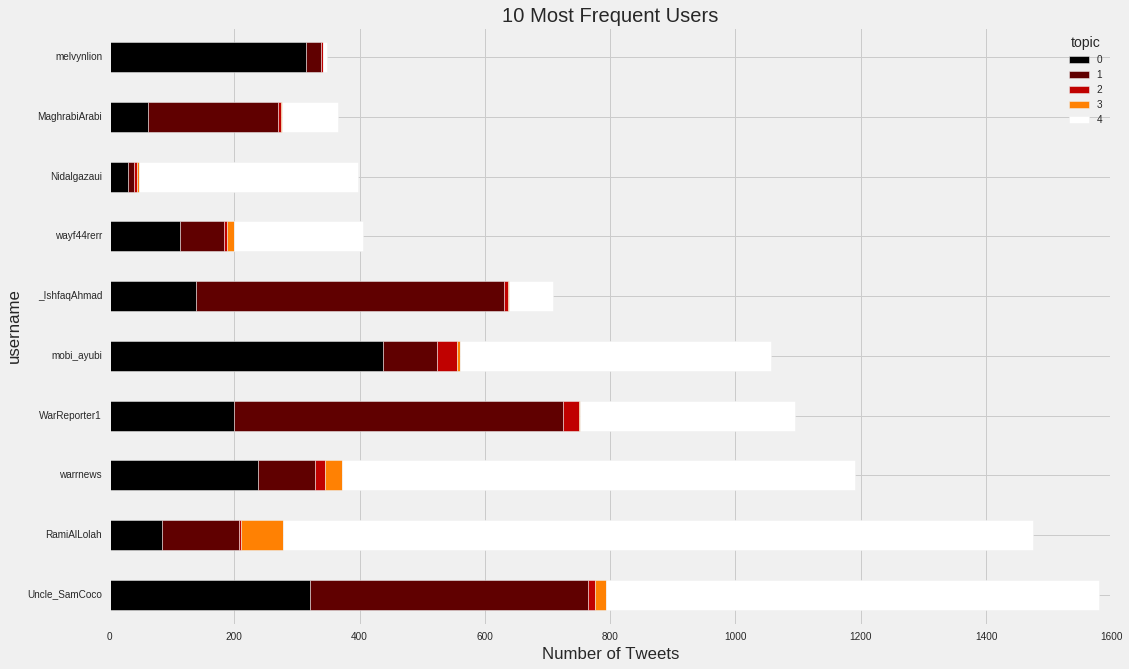

In [353]:
fig, ax = plt.subplots(figsize = (20,15))
style.use('fivethirtyeight')



df['topic'] = np.argmax(model.transform(Tfidf_vectorizer.transform(df.tweets)), axis=1)
top10_users = df[df.username.isin(df.username.value_counts()[:10].keys().tolist())]
tb = pd.crosstab(top10_users.username, top10_users.topic)
tb['sum'] = tb.sum(axis=1)
#pd.crosstab(top10_users.username, top10_users.topic).plot(kind='barh',stacked=True, figsize=(16, 10), colormap="gist_heat", ax = ax)
tb.sort_values('sum', ascending=False).iloc[:,:5].plot(kind='barh',stacked=True, figsize=(16, 10), colormap="gist_heat", ax =ax)

ax.set_title('10 Most Frequent Users')
ax.set_xlabel('Number of Tweets')
